# Learning value-function in Blackjack

In [1]:
using StatsBase
using Plots

In [2]:
deck = collect(1:13)
deck[end-2:end] .= 10;
println(deck)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


* **Stick**: Player stops
* **Hit**: Request an additional card

In [309]:
"""
Draw a card from an i.i.d deck.
Values of 10 correspond to cards 10, Jack, Queen, and King.
"""
function draw_cards(n=1)
    n_vals = ones(10)
    n_vals[end] = 4
    deck_probs = ProbabilityWeights(n_vals) # Unnormalised probabilities
    cards = n == 1 ? sample(deck_probs) : sample(1:10, deck_probs, n)
    
    return cards
end


function update_value_cards(value_cards, has_usable_ace)
    new_card = draw_cards(1)
    value_card, usable_ace = (value_cards <= 10) && (new_card == 1) ? (11, true) : (new_card, false)
    value_cards = value_cards + value_card
    has_usable_ace = has_usable_ace || usable_ace
    
    return value_cards, has_usable_ace
end

"""
Random initialisation of the player's card. At the
beginning, we draw two cards. If the sum of the cards
is less than 12, we continue hitting until we reach at
least 12.

Returns
-------
* Initial cards
* Initial value of cards
* Whether there is a usable ace
"""
function init_state()
    init_cards = draw_cards(2)
    has_usable_ace = any(1 .∈ init_cards)
    
    value_cards = sum(init_cards) + 10 * has_usable_ace
    
    while value_cards < 12
        value_cards, has_usable_ace = update_value_cards(value_cards, has_usable_ace)
    end
    
    return init_cards, value_cards, has_usable_ace
    
end


"""
Create initial state of Blackjack game

Returns
-------
* array: sum of player's hand, whether player holds a usable ace, dealer's only showing card
* int: initial value of dealer's hand
"""
function init_game()
    _, player_value, player_usable_ace = init_state()
    dealer_cards, dealer_value, _ = init_state()
    dealer_card = dealer_cards[1]
    
    init_player_state = [player_value, player_usable_ace, dealer_card], dealer_value
end

init_game

In [298]:
function is_draw()
end


"""
Compute a single step of Blackjack

Parameters
----------
state: array(3)
    * Player's current sum
    * Whether player has usable ace
    * Dealer's one-showing card
policy array(10, 2, 10)
    Policy grid specifying whether to "hit"
    or "stick". The dimensions are specified as follows:
    1. Index of card values: 12, ..., 21
    2. Action values: hit, stick
    3. Dealer's one-showing card: 1, ..., 10
"""
function blackjack_step(state, dealer_value, policy)
    end_of_game = false
    reward = 0
    player_val, usable_ace, dealer_card = state
    
    player_ix = player_val - 11 # From value card to index in policy grid
    ace_ix = usable_ace + 1 # From bool to index in policy grid

    
    # Check whether player wants another card
    hit_player = Bool(policy[player_ix, ace_ix, dealer_card])
    
    # It's a draw
    if player_val == dealer_value == 21
        end_of_game = true
    # Player wins with 21
    elseif player_val == 21
        reward = 1
        end_of_game = true
    # Dealer wins with 21
    elseif dealer_value == 21
        reward = -1
        end_of_game = true
    # No player wants to hit
    elseif dealer_value >= 17 && !hit_player
        reward = dealer_value > player_val ? -1 : 1
        end_of_game = true
    # ** Continue playing **
    elseif dealer_value < 17 && !hit_player
        dealer_value = dealer_value + draw_cards()
    elseif dealer_value >= 17 && hit_player
        player_val = player_val + draw_cards()
    elseif dealer_value < 17 && hit_player
        dealer_value, _ = update_value_cards(dealer_value, true)
        player_val, usable_ace = update_value_cards(player_val)
    end
    
    new_state = 
end

blackjack_step

In [299]:
init_game()

([14, 1, 6], 16)

In [164]:
# Initial test policy
policy = zeros((10, 2, 10))
policy[1:end-2, 1, :] .= 1 # Sum less than 20 => hits
policy[end-2:end, 1, :] .= 1; # Sum == 20 or sum == 21 => stick

# Deprecated

In [61]:
"""
**Fixed strategy**  
The dealer sticks on any sum of 17 or greater, and hits otherwise.
"""
function dealer_strategy(value_cards)
    while value_cards < 17
        value_cards = value_cards + sample(deck)
    end
    
    return value_cards
end


"""
Policy in which a player sticks only if his sum
is 20 or 21.
"""
function policy(value_cards, dealer_one_card)
    while value_cards < 20
        value_cards = value_cards + sample(deck)
    end
    return value_cards
end

policy

In [138]:
function blackjack(player_value_cards, dealer_cards, policy)
    reward = 0
    
    # is the dealer allowed to use a 'usable' ace?
    # dealer_value_cards = sum(turn_usable_ace(dealer_cards...)[1])
    dealer_value_cards = sum(dealer_cards)
    
    
    if player_value_cards == 21 && dealer_value_cards != 21
        reward = 1
        return reward, (player_value_cards, dealer_value_cards)
    end
    
    player_value_cards = policy(player_value_cards, dealer_cards[1])
    
    if player_value_cards > 21
        reward = -1
    else
        dealer_value_cards = dealer_strategy(dealer_value_cards)
        if dealer_value_cards > 21
            reward = 1
        else
            reward = player_value_cards > dealer_value_cards ? 1 : 0
        end
    end
    
    return reward, (player_value_cards, dealer_value_cards)
end

blackjack (generic function with 2 methods)

In [139]:
dealer = sample(deck, 2)
player = sample(deck, 2)

player, has_usable_ace = turn_usable_ace(player...)
player_value_cards = max(12, sum(player))

20

In [140]:
"""
Given a pair of cards, check whether any
of the cards has an ace and its usable. If it's
usable, we turn its value into an 11
"""
function turn_usable_ace(card1, card2)
    has_usable_ace = false
    
    if card1 == 1 && 11 + card2 <= 21
        card1 = 11
        has_usable_ace = true
        
    elseif card2 == 1 && 11 + card1 <= 21
        card2 = 11
        has_usable_ace = true
        
    end
    
    return (card1, card2), has_usable_ace
end


turn_usable_ace

In [149]:
value_matrix = zeros(2, 11, 11)
count_matrix = zeros(2, 11, 11)

for _ in 1:100_000
    dealer = sample(deck, 2)
    player = sample(deck, 2)
    
    dealer_shown_card = dealer[1]

    player, has_usable_ace = turn_usable_ace(player...)
    
    has_usable_ace = has_usable_ace + 1
    player_value_cards = max(12, sum(player))
        
    reward, final_cards = blackjack(player_value_cards, dealer, policy)
    
    value_matrix[has_usable_ace, dealer_shown_card, player_value_cards - 11] += reward 
    count_matrix[has_usable_ace, dealer_shown_card, player_value_cards - 11] += 1
end

In [157]:
avg_matrix = value_matrix ./ max.(count_matrix, 1)

11×11 Matrix{Float64}:
 -0.553284  -0.53748   -0.590476  -0.628774  …  -0.704871  0.710042  0.0  0.0
 -0.479452  -0.589109  -0.580065  -0.600753     -0.678977  0.762238  0.0  0.0
 -0.489487  -0.54201   -0.584939  -0.587902     -0.814917  0.769746  0.0  0.0
 -0.504595  -0.593931  -0.593592  -0.690909     -0.737662  0.754026  0.0  0.0
 -0.526293  -0.601538  -0.601386  -0.629295     -0.692098  0.794667  0.0  0.0
 -0.521496  -0.515432  -0.586207  -0.598901  …  -0.696793  0.777778  0.0  0.0
 -0.515419  -0.5152    -0.573379  -0.547135     -0.713433  0.834247  0.0  0.0
 -0.523176  -0.522551  -0.563478  -0.616698     -0.675     0.873641  0.0  0.0
 -0.492644  -0.502564  -0.527337  -0.59203      -0.702186  0.857347  0.0  0.0
 -0.544341  -0.590294  -0.602542  -0.637358     -0.740716  0.597407  0.0  0.0
  0.0        0.0        0.0        0.0       …   0.0       0.0       0.0  0.0

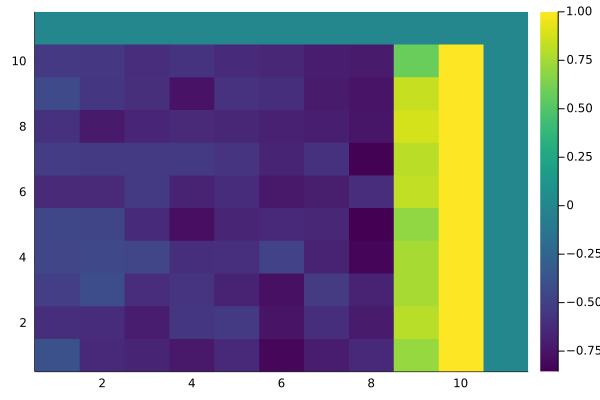

In [164]:
heatmap(avg_matrix[2, :, :], color=:viridis)